# 2.- Euler-Maruyama method

Once we have reviewed basic concepts about probability and sampling distributions using `numpy`, we can delve into the 
technical core of this project. The objective of this notebook is to introduce the Euler-Maruyama (EM) method to numerically solve a Stochastic differential equation (SDE). Before presenting the numerical method, we provide a brief explanation of what is an SDE and what are the main components. We then describe the Brownian motion and its relationship with Gaussian normal distributions. The Brownian motion is the fundamental building block to understand and solve SDEs. We conclude explaining the EM method and how to implement it using `numpy` functionalities.

## Contents
### [A. Stochastic differential equations](#sde)
### [B. Brownian Motion](#brownian)
### [C. Euler-Maruyama method](#em)

<a id="sde"></a>
### A. Stochastic differential equations

An SDE is a mathematical equation describing the dynamics of a system or process subject to deterministic and random influences. It formulates the time-evolution equation of variables with inherent randomness. By seamlessly incorporating random terms, SDEs offer a powerful framework for analysing and understanding random variable behaviour. As a result, they find wide-ranging applicability in fields such as biology, finance and physics.

Although there are different types of SDEs, we restrict our attention to the following type of SDE, so-called Itô SDE. Considering that $X_t$ represents the variable we are interested at time $t$, its related SDE is written in the form of:

\begin{align}
dX_{t} = \mu(X_t, t)dt + \sigma(X_t, t) dW_t.
\end{align}

Now, we explain each component of the equation above.

* $dX_t$ is the differential of $X_t$, i.e., a small (infinitesimal) change of $X_t$. 


* $\mu(X_t, t)dt$ is the **drift** term. It represents the deterministic force driving the expected or average rate of change in $X_t$ at time $t$. In general, the drift coefficient $\mu(\cdot)$ can be a function of the process value $X_t$ and the time step $t$ as represented here or it can be a constant, $\mu(X_t, t) = \mu$. $dt$ represents the differential of time. As we will see later, this term informs about the trend behaviour of $X$ over time.


* $\sigma(X_t, t)dW_t$ is the **diffusion** term. It represents the stochastic part of the equation, introducing the random behaviour. The term $\sigma(X_t, t)$ is called the diffusion coefficient and it is inherently related to the volatility or uncertainty evolution of the variable $X_t$ at time $t$. Like the drift coefficient, the diffusion coefficient can be a function of the process value $X_t$ and be time-dependent $t$ or it can be a constant $\sigma(X_t, t) = \sigma$. $W_t$ is a Wiener process, so-called **Brownian motion**. It involves the random fluctuation of the variable $X$ injecting random noise in the time-evolution equation. We will provide a detailed explanation of the Brownian motion and its implications in the next subsection. Now, we can think of the Brownian motion as a noise generator that follows a Gaussian distribution $W_t \sim \mathcal{N(0, t)}$.

For a more comprehensive understanding of stochastic differential equations, we recommend referring to this [book](https://link.springer.com/book/10.1007/978-3-662-12616-5).

<a id="brownian"></a>
### B. Brownian motion

In the previous section, we mentioned that $W_t$ is a Wiener process or Brownian motion. The aim of this section is to explain the concept of Brownian motion, its significance in generating random solutions of SDEs, and its implications. While our explanation focuses on intuition rather than rigorous mathematical formalism, it provides an accesible understanding of Brownian motion. For a more detailed explanation of Brownian motion or Wiener process, the reader can refer to these two sources: [link 1](https://www.wiley.com/en-sg/Brownian+Motion+Calculus-p-9780470021705) and [link 2](https://www.amazon.com/Introduction-Stochastic-Processes-Physics-Paperback/dp/080186867X).

Brownian motion is essentially a random process that was first observed by the botanist Robert Brown in 1827. It describes the erratic and irregular trajectories of small pollen grains suspended in water. This random phenomenon remained unexplained for many years. In the early 20th century, Albert Einstein, Marian Smoluchowski, and Paul Langevin developed a set of physical explanations of Brown's observations. Specifically, the work of Paul Langevin in 1908 ["On the Theory of Brownian Motion"](https://www.physik.uni-augsburg.de/theo1/hanggi/History/Langevin1908.pdf) is the considered the foundation of SDEs, since this publication contains the first appearance of an SDE describing the displacement of individual particles inmersed in a fluid.

Instead of following the physical reasoning behind Langevin's work, we adopt an intuitive approach to define Brownian motion by considering a symmetric random walk. First, we divide the real half-line $[0, \infty)$ into small non-overlapping intervals of length $\delta$, so that the $k$th interval is $((k-1)\delta, \, k\delta]$. Now we consider that for each interval we toss a unbiased coin *independently* and we define the following random variable:

\begin{align}
X_k = \left\{
\begin{array}{l l}
\sqrt{\delta} & \quad \textrm{if the coin toss is heads} \\
& \quad \\
-\sqrt{\delta} & \quad \textrm{if the coin toss is tails}
\end{array} \right.
\end{align}

This means that $P\left( X_k = \sqrt{\delta} \right) = 0.5$ and $P\left( X_k = -\sqrt{\delta} \right) = 0.5$, where $\mathbb{E}[X_k] = 0$ and $Var(X_k) = \delta$. We define now a process $W_t$, with $t=n\delta$ as follows:

\begin{align}
W_t = W_{(n\delta)} = \sum\limits_{k=1}^{n} X_k,
\end{align}

with $W_0 = 0$ as the initial condition. This means that $W_t$ is a process accumulating all coin tosses results up to time $t$. By utilising statistical properties of *independent* sums of random variables and the central limit theorem, whose explanation is beyond the scope of this project, we obtain:

\begin{align}
\mathbb{E}[W_t] = \sum\limits_{k=1}^{n} \mathbb{E}[X_k] = 0 \quad Var(W_t) = \sum\limits_{k=1}^{n} Var(X_k) = n Var(X_k) = n \delta = t \qquad \text{if } n \rightarrow \infty, t \rightarrow 0 \qquad W_t \sim \mathcal{N}(0, t).
\end{align}

The process $W_t$ is called a standard Brownian motion because it follows a normal random variable. Let us write a small code to simulate this Brownian motion, $W_t$, in order to understand its behaviour.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# First, we define the random variable x_k
def get_x_k(delta: float):
    coin = np.random.rand()  # coin toss
    if coin < 0.5:  # equivalent to heads
        return np.sqrt(delta)
    else:  # equivalent to tails
        return (-1)*np.sqrt(delta)

# We define the process W_t for a number of steps n and length delta
def compute_w_t(n: int, delta:float):
    w_t = np.zeros(n)
    w_t[0] = 0  # recall the initial condition, by definition W_0 = 0
    for i in range(1, n):
        w_t[i] = get_x_k(delta=delta)
        
    # Apply the cumulative sum to represent W_t at time t
    w_t = np.cumsum(w_t)
    
    return w_t 

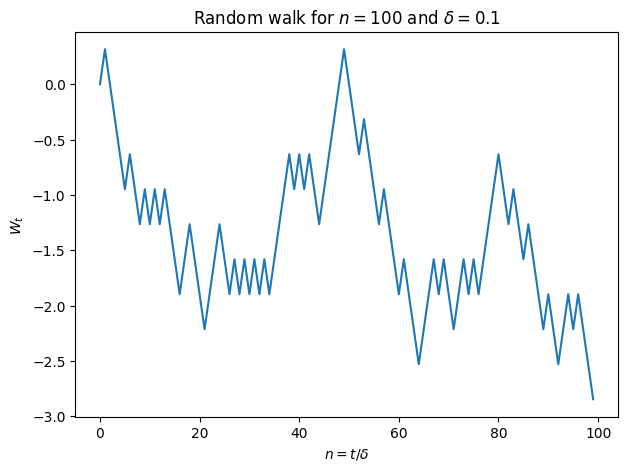

In [3]:
# Compute the process and plot the result
w_t = compute_w_t(n=100, delta=0.1)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(w_t)
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$W_t$")
ax.set_title(f"Random walk for $n=100$ and $\delta=0.1$")
plt.show()

We have obtained our first Brownian motion, which is simply a random walk. However, it does not resemble an erratic and fluctuating walk. Remember that as $n \rightarrow \infty$ and $\delta \rightarrow 0$, we meet the conditions to obtain a proper Brownian motion. So, let us repeat the random walk while adjusting $n, \delta$.

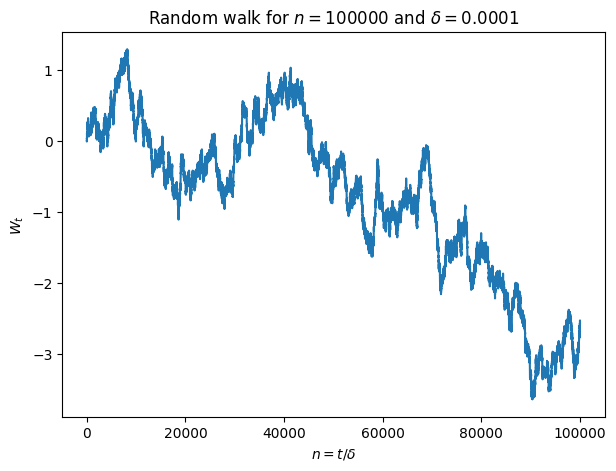

In [4]:
w_t = compute_w_t(n=100_000, delta=0.0001)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(w_t)
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$W_t$")
ax.set_title(f"Random walk for $n=100000$ and $\delta=0.0001$")
plt.show()

This looks much more like a genuine random walk! However, since we are only using a fair coin toss with equal probabilities for heads and tails, where does the random normal behavior come into play here? To illustrate the connection of our random walk (Brownian motion) with the normal random variable, we must consider an ensemble of random walks. Let us code it!

In [5]:
# Define the random variable x_k over multiple realisations
def get_multiple_x_k(delta: float, size: int):
    coins = np.random.rand(size)  # coin toss
    result = np.ones(size) * (-1)**(coins < 0.5) * np.sqrt(delta)  # (-1)**True = -1; (-1)**False = 1
    return result

def compute_multiple_w_t(n: int, delta:float, size: int):
    w_t = np.zeros(shape=(n, size))
    w_t[0, :] = 0  # recall the initial condition, by definition W_0 = 0
    for i in range(1, n):
        w_t[i, :] = get_multiple_x_k(delta=delta, size=size)
        
    # Apply the cumulative sum to represent W_t at time t
    w_t = np.cumsum(w_t, axis=0)
    
    return w_t 

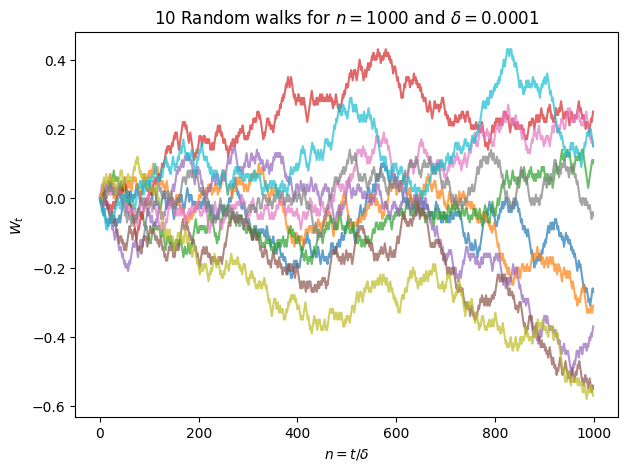

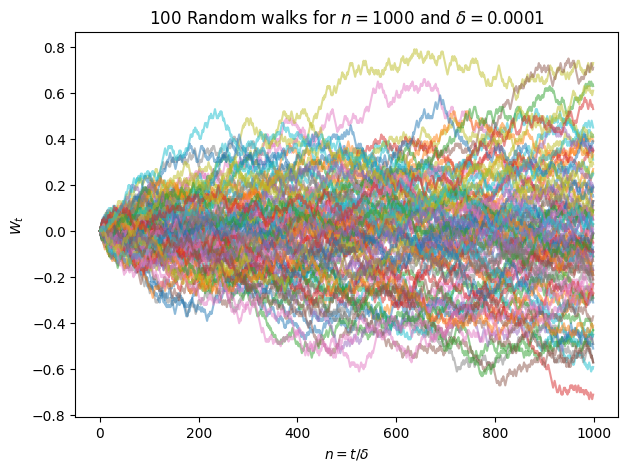

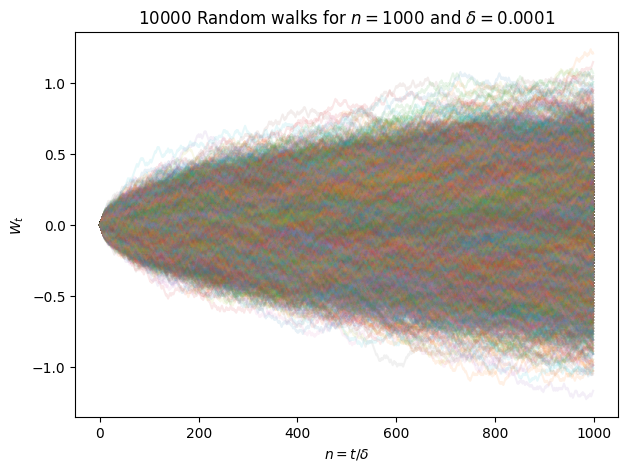

In [6]:
delta = 0.0001
multiple_10_w_t = compute_multiple_w_t(n=1000, delta=delta, size=10)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(multiple_10_w_t, alpha=.7)
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$W_t$")
ax.set_title(f"10 Random walks for $n=1000$ and $\delta=0.0001$")
plt.show()

multiple_100_w_t = compute_multiple_w_t(n=1000, delta=delta, size=100)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(multiple_100_w_t, alpha=.5)
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$W_t$")
ax.set_title(f"100 Random walks for $n=1000$ and $\delta=0.0001$")
plt.show()

multiple_10000_w_t = compute_multiple_w_t(n=1000, delta=delta, size=10_000)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(multiple_10000_w_t, alpha=.1)
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$W_t$")
ax.set_title(f"10000 Random walks for $n=1000$ and $\delta=0.0001$")
plt.show()

Now, we start to see a pattern in the ensemble of random walks. According to the definition provided above, $W_t \sim \mathcal{N}(0, t)$. This implies that the random walks generated must approximate to a Gaussian normal distribution with mean 0 and variance $t$ at each time $t$. Let us check this statement by analysing the random walk results at three different time steps, namely $t_1=100\delta$, $t_2=500\delta$, and $t_3=1000\delta$:    

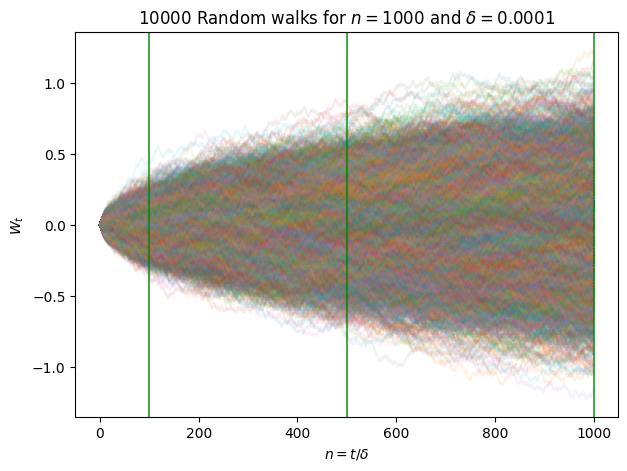

In [7]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(multiple_10000_w_t, alpha=.1)
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$W_t$")
ax.set_title(f"10000 Random walks for $n=1000$ and $\delta=0.0001$")
ax.axvline(x=100, ymin=0, ymax=1, color="green", alpha=0.7)
ax.axvline(x=500, ymin=0, ymax=1, color="green", alpha=0.7)
ax.axvline(x=1000, ymin=0, ymax=1, color="green", alpha=0.7)
plt.show()

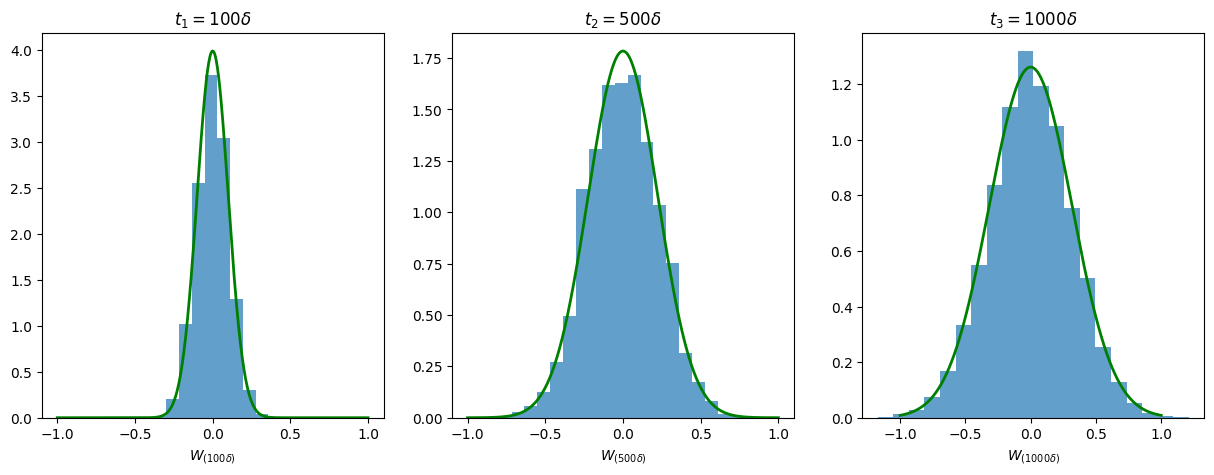

In [8]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))

x = np.linspace(-1, 1, 500)
var_100 = 100*delta
normal_function_100 = 1/np.sqrt(2*np.pi*var_100)*np.exp(-x**2/(2*var_100))
ax0.hist(multiple_10000_w_t[100, :], alpha=.7, density=True)
ax0.plot(x, normal_function_100, color="green", lw=2)
ax0.set_xlabel(r"$W_{(100\delta)}$")
ax0.set_title(r"$t_1=100\delta$")

var_500 = 500*delta
normal_function_500 = 1/np.sqrt(2*np.pi*var_500)*np.exp(-x**2/(2*var_500))
ax1.hist(multiple_10000_w_t[500, :], alpha=.7, density=True, bins=20)
ax1.plot(x, normal_function_500, color="green", lw=2)
ax1.set_xlabel(r"$W_{(500\delta)}$")
ax1.set_title(r"$t_2=500\delta$")

var_1000 = 1000*delta
normal_function_1000 = 1/np.sqrt(2*np.pi*var_1000)*np.exp(-x**2/(2*var_1000))
ax2.hist(multiple_10000_w_t[1000-1, :], alpha=.7, density=True, bins=20)
ax2.plot(x, normal_function_1000, color="green", lw=2)
ax2.set_xlabel(r"$W_{(1000\delta)}$")
ax2.set_title(r"$t_3=1000\delta$")

plt.show()

We can observe how, for each time step $t$, the samples obtained from the random walks approximate a Gaussian normal distribution $\mathcal{N}(0, t)$.

As an additional example to illustrate the relationship between Brownian motion and the Gaussian distribution, we plot the time-evolution of the 99% region probability of the values of the random walk. Based on the properties of the normal distribution, we know that the approximately 99.7% of the values drawn from a normal distribution lie within 3 standard deviations with respect to the mean value, i.e. $[\mu - 3\sigma, \mu + \sigma]$. This means that for a standard normal distribution, $\mathcal{N}(0, 1)$, there is ~99.7% probabilty of obtaining a random sample within $[0 - 3 \cdot 1, 0 + 3 \cdot 1] = [-3, 3]$. By considering both extremes of the 99% interval at every time step of the random walk, we can generate the following graph.

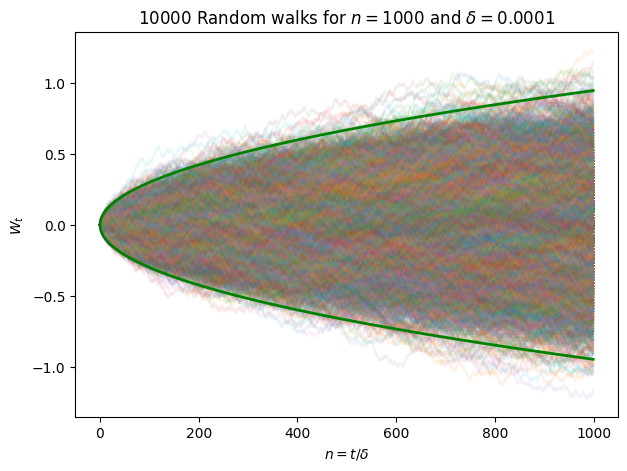

In [9]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(multiple_10000_w_t, alpha=.1)
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$W_t$")
ax.set_title(f"10000 Random walks for $n=1000$ and $\delta=0.0001$")

# Since at every time step, t, W_t follows N(0, t), the standard deviation at t=n*delta is sqrt(t) = sqrt(n*delta)
std = np.sqrt(np.arange(0, 1_000) * delta)

ax.plot(3*std, color="green", lw=2)
ax.plot(-3*std, color="green", lw=2)

plt.show()

The area enclosed by the green lines represents the 99% region probability. This indicates that there is a 99% likelihood of the random walk falling within these boundaries. We can observe that, as time increases (n increases in this example), the 99% probability interval also expands. This means that our uncertainty, reflected here as the random walk dispersion, increases as time evolves. 

The inherent simplicity and subtle nature of Brownian motion make it a really powerful to model stochastic processes and capture the growing uncertainty over time in the form of noise injection. This behaviour resembles many natural and social phenomena, where our confidence in predicting future outcomes diminishes as the time horizon lengthens.

So far, we have dealt with simple Brownian motion, $W_t \sim \mathcal{N}(0, t)$. This process assumes that the initial condition is zero and there is equal probability of going up or down according to our untuitive coin toss definition. However, if some reason, we know that our process must follow a deterministic time-evolution, we can easily incorporate a Brownian motion on top of the deterministic function. Let us see a couple of examples.

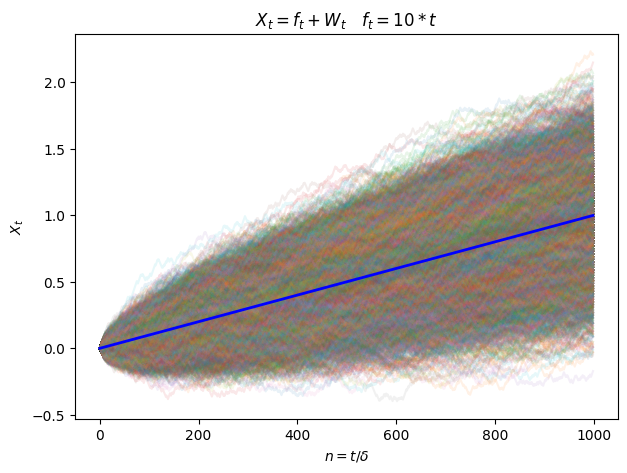

In [10]:
# A simple linear function of time
# f = 10*t
f = 10 * np.arange(0, 1_000) * delta 
x = multiple_10000_w_t + f.reshape(-1, 1)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(x, alpha=.1)
ax.plot(f, lw=2, color="blue")
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$X_t$")
ax.set_title(f"$X_t = f_t + W_t \quad f_t = 10*t$")
plt.show()

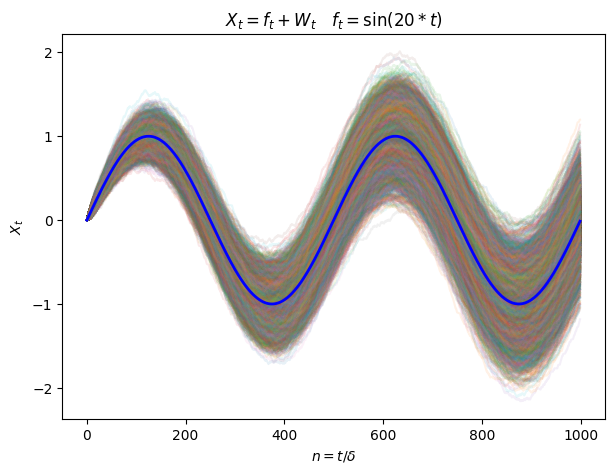

In [11]:
# An oscillating signal
# f = sin(20*t)
f = np.sin(np.arange(0, 1_000) * delta * 2*np.pi * 20)
x = multiple_10000_w_t + f.reshape(-1, 1)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(x, alpha=.1)
ax.plot(f, lw=2, color="blue")
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$X_t$")
ax.set_title(f"$X_t = f_t + W_t \quad f_t = \sin(20*t)$")
plt.show()

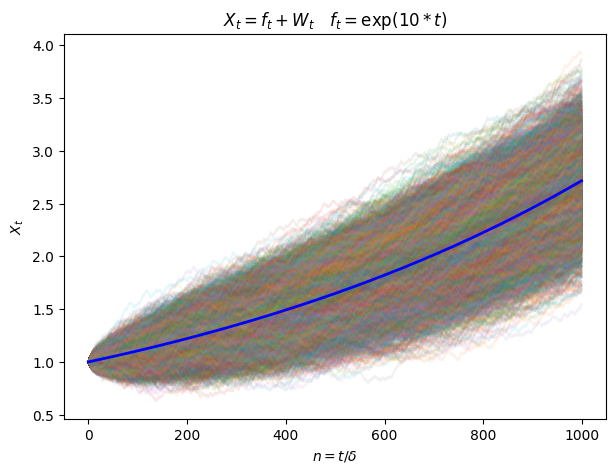

In [12]:
# An exponential signal
# f = exp(10*t)
f = np.exp(np.arange(0, 1_000) * delta * 10)
x = multiple_10000_w_t + f.reshape(-1, 1)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(x, alpha=.1)
ax.plot(f, lw=2, color="blue")
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$X_t$")
ax.set_title(f"$X_t = f_t + W_t \quad f_t = \exp(10*t)$")
plt.show()

These examples demonstrate the simplicity of building random functions by incorporating noise in the form of Brownian motion into a deterministic function. We are getting closer to being able to solve an SDE like the one introduced at the beginning of the notebook.